In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

#Build the encoder
encoder_inputs = keras.Input(shape=(88, 1))
x = layers.Conv1D(8, 3, activation='relu', padding='same', dilation_rate=2)(encoder_inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same', dilation_rate=2)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
encoder = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(88 * 8)(x)
x = layers.Reshape((88, 8))(x)
x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.UpSampling1D(2)(x)
decoded = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
decoded = layers.Cropping1D(cropping=(0, 264))(decoded)
decoder = keras.Model(latent_inputs, decoded, name="decoder")
decoder.summary()

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum((data - reconstruction) ** 2, axis=(1, 2))
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + 0.4 * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def test_step(self, data):
        x = data

        z_mean, z_log_var, z = self.encoder(x, training=False)
        reconstructed_x = self.decoder(z, training=False)

        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum((x - reconstructed_x) ** 2, axis=(1, 2))
        )

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

        total_loss = reconstruction_loss + 0.4 * kl_loss

        results = {m.name: m.result() for m in self.metrics}
        results["reconstruction_loss"] = reconstruction_loss
        results["kl_loss"] = kl_loss
        results["total_loss"] = total_loss
        return results



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 88, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 88, 8)        32          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 44, 8)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 44, 16)       400         ['max_pooling1d[0][0]']          
                                                                                            

In [2]:
from sklearn.preprocessing import MinMaxScaler

features = pd.read_csv('features.csv')
labels = pd.read_csv('labels.csv')
(x_train, x_test, y_train, y_test) = train_test_split(
                                    features, labels, test_size=0.2, random_state=42)

x_train_seq = x_train.values[:, 0]
x_test_seq = x_test.values[:, 0]

x_train_features = x_train.values[:, 1:]
x_test_features = x_test.values[:, 1:]

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train_features)
x_test = scaler.transform(x_test_features)

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
y_train = np.expand_dims(y_train, -1)
y_test = np.expand_dims(y_test, -1)

In [3]:
learn_rate = [0.001, 0.005, 0.008, 0.01]
batch_size = [32, 64, 128, 256]

param_grid = dict(learn_rate=learn_rate, batch_size=batch_size)

best_score = None
best_params = {}

for lr in learn_rate:
    for bs in batch_size:
        print("Learning rate: ", lr)
        print("Batch size: ", bs)
        
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        
        reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
        early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)
        
        vae.fit(x_train, batch_size=bs, epochs=30, validation_split = 0.2, 
                callbacks=[reduce_lr, early_stop])

        score = vae.evaluate(x_test)
        print(score)

        if best_score is None or score < best_score:
            best_score = score
            best_params = {'learn_rate': lr, 'batch_size': bs}

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

lr = best_params['learn_rate']
bs = best_params['batch_size']

Learning rate:  0.001
Batch size:  32
Epoch 1/30
210/210 [==============================] - 3s 8ms/step - loss: 1.3716 - reconstruction_loss: 1.2007 - kl_loss: 0.0085 - val_total_loss: 1.0950 - val_reconstruction_loss: 1.0907 - val_kl_loss: 0.0107 - lr: 0.0010
Epoch 2/30
210/210 [==============================] - 1s 6ms/step - loss: 1.0410 - reconstruction_loss: 1.0119 - kl_loss: 0.0055 - val_total_loss: 1.0682 - val_reconstruction_loss: 1.0657 - val_kl_loss: 0.0062 - lr: 0.0010
Epoch 3/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9835 - reconstruction_loss: 0.9726 - kl_loss: 0.0041 - val_total_loss: 1.0084 - val_reconstruction_loss: 1.0068 - val_kl_loss: 0.0039 - lr: 0.0010
Epoch 4/30
210/210 [==============================] - 1s 6ms/step - loss: 0.9644 - reconstruction_loss: 0.9577 - kl_loss: 0.0056 - val_total_loss: 1.0118 - val_reconstruction_loss: 1.0100 - val_kl_loss: 0.0044 - lr: 0.0010
Epoch 5/30
210/210 [==============================] - 1s 6ms/step - lo

105/105 [==============================] - 1s 9ms/step - loss: 0.9291 - reconstruction_loss: 0.8344 - kl_loss: 0.2039 - val_total_loss: 0.9218 - val_reconstruction_loss: 0.8108 - val_kl_loss: 0.2776 - lr: 0.0010
Epoch 7/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9156 - reconstruction_loss: 0.8399 - kl_loss: 0.2094 - val_total_loss: 0.8060 - val_reconstruction_loss: 0.6910 - val_kl_loss: 0.2875 - lr: 0.0010
Epoch 8/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9151 - reconstruction_loss: 0.8352 - kl_loss: 0.2114 - val_total_loss: 1.0206 - val_reconstruction_loss: 0.9193 - val_kl_loss: 0.2533 - lr: 0.0010
Epoch 9/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9230 - reconstruction_loss: 0.8374 - kl_loss: 0.2051 - val_total_loss: 0.9261 - val_reconstruction_loss: 0.8054 - val_kl_loss: 0.3017 - lr: 0.0010
Epoch 10/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9214 - reconstruction_loss: 0.8345 - kl_lo

Epoch 10/30
53/53 [==============================] - 1s 17ms/step - loss: 0.9310 - reconstruction_loss: 0.8302 - kl_loss: 0.2277 - val_total_loss: 0.9474 - val_reconstruction_loss: 0.8350 - val_kl_loss: 0.2810 - lr: 0.0010
Epoch 11/30
53/53 [==============================] - 1s 17ms/step - loss: 0.9313 - reconstruction_loss: 0.8287 - kl_loss: 0.2220 - val_total_loss: 0.8753 - val_reconstruction_loss: 0.7512 - val_kl_loss: 0.3103 - lr: 0.0010
Epoch 12/30
53/53 [==============================] - 1s 16ms/step - loss: 0.8985 - reconstruction_loss: 0.8285 - kl_loss: 0.2227 - val_total_loss: 1.0442 - val_reconstruction_loss: 0.9264 - val_kl_loss: 0.2946 - lr: 0.0010
Epoch 13/30
52/53 [============================>.] - ETA: 0s - loss: 0.9187 - reconstruction_loss: 0.8277 - kl_loss: 0.2251
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
53/53 [==============================] - 1s 16ms/step - loss: 0.9185 - reconstruction_loss: 0.8243 - kl_loss: 0.2255 - val_total_l

Epoch 14/30
25/27 [==========================>...] - ETA: 0s - loss: 0.9117 - reconstruction_loss: 0.8319 - kl_loss: 0.2194
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 [==============================] - 1s 28ms/step - loss: 0.9123 - reconstruction_loss: 0.8295 - kl_loss: 0.2205 - val_total_loss: 0.9416 - val_reconstruction_loss: 0.8172 - val_kl_loss: 0.3110 - lr: 0.0010
Epoch 15/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9187 - reconstruction_loss: 0.8311 - kl_loss: 0.2224 - val_total_loss: 0.9319 - val_reconstruction_loss: 0.8262 - val_kl_loss: 0.2643 - lr: 5.0000e-04
Epoch 16/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9052 - reconstruction_loss: 0.8265 - kl_loss: 0.2222 - val_total_loss: 0.9074 - val_reconstruction_loss: 0.7884 - val_kl_loss: 0.2975 - lr: 5.0000e-04
Epoch 17/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9097 - reconstruction_loss: 0.8242 - kl_loss: 0.2278 - val

Epoch 27/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9348 - reconstruction_loss: 0.8330 - kl_loss: 0.2127 - val_total_loss: 0.9352 - val_reconstruction_loss: 0.8020 - val_kl_loss: 0.3329 - lr: 0.0012
Epoch 28/30
210/210 [==============================] - 2s 8ms/step - loss: 0.9118 - reconstruction_loss: 0.8289 - kl_loss: 0.2266 - val_total_loss: 0.9597 - val_reconstruction_loss: 0.8122 - val_kl_loss: 0.3688 - lr: 0.0012
Epoch 29/30
206/210 [============================>.] - ETA: 0s - loss: 0.9246 - reconstruction_loss: 0.8305 - kl_loss: 0.2229
Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Restoring model weights from the end of the best epoch: 19.
210/210 [==============================] - 1s 7ms/step - loss: 0.9245 - reconstruction_loss: 0.8291 - kl_loss: 0.2220 - val_total_loss: 0.8551 - val_reconstruction_loss: 0.7021 - val_kl_loss: 0.3826 - lr: 0.0012
Epoch 29: early stopping
66/66 [==============================] - 0s 2ms/step

Epoch 30/30
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9047 - reconstruction_loss: 0.8052 - kl_loss: 0.2487
[0.9046738743782043, 0.8051981329917908, 0.24868933856487274]
Learning rate:  0.005
Batch size:  128
Epoch 1/30
53/53 [==============================] - 3s 20ms/step - loss: 0.9161 - reconstruction_loss: 0.8362 - kl_loss: 0.2211 - val_total_loss: 1.2051 - val_reconstruction_loss: 1.0831 - val_kl_loss: 0.3049 - lr: 0.0050
Epoch 2/30
53/53 [==============================] - 1s 16ms/step - loss: 0.9216 - reconstruction_loss: 0.8368 - kl_loss: 0.2146 - val_total_loss: 0.9671 - val_reconstruction_loss: 0.8481 - val_kl_loss: 0.2976 - lr: 0.0050
Epoch 3/30
53/53 [==============================] - 1s 16ms/step - loss: 0.9161 - reconstruction_loss: 0.8440 - kl_loss: 0.2111 - val_total_loss: 0.8187 - val_reconstruction_loss: 0.6920 - val_kl_loss: 0.3168 - lr: 0.0050
Epoch 4/30
53/53 [==============================] - 1s 16ms/step - loss: 0.9217 - reconstruction_lo

27/27 [==============================] - 1s 28ms/step - loss: 0.9077 - reconstruction_loss: 0.8297 - kl_loss: 0.2237 - val_total_loss: 0.9657 - val_reconstruction_loss: 0.8551 - val_kl_loss: 0.2765 - lr: 0.0050
Epoch 4/30
27/27 [==============================] - 1s 29ms/step - loss: 0.8925 - reconstruction_loss: 0.8202 - kl_loss: 0.2141 - val_total_loss: 0.9613 - val_reconstruction_loss: 0.8610 - val_kl_loss: 0.2508 - lr: 0.0050
Epoch 5/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9132 - reconstruction_loss: 0.8264 - kl_loss: 0.2209 - val_total_loss: 0.9538 - val_reconstruction_loss: 0.8296 - val_kl_loss: 0.3106 - lr: 0.0050
Epoch 6/30
27/27 [==============================] - 1s 29ms/step - loss: 0.9110 - reconstruction_loss: 0.8287 - kl_loss: 0.2176 - val_total_loss: 0.9535 - val_reconstruction_loss: 0.8238 - val_kl_loss: 0.3243 - lr: 0.0050
Epoch 7/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9177 - reconstruction_loss: 0.8324 - kl_loss: 0.

210/210 [==============================] - 1s 7ms/step - loss: 0.9336 - reconstruction_loss: 0.8352 - kl_loss: 0.2182 - val_total_loss: 0.8968 - val_reconstruction_loss: 0.7785 - val_kl_loss: 0.2956 - lr: 0.0020
Epoch 22/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9065 - reconstruction_loss: 0.8327 - kl_loss: 0.2107 - val_total_loss: 0.9422 - val_reconstruction_loss: 0.8211 - val_kl_loss: 0.3029 - lr: 0.0020
Epoch 23/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9330 - reconstruction_loss: 0.8354 - kl_loss: 0.2148 - val_total_loss: 1.0457 - val_reconstruction_loss: 0.9371 - val_kl_loss: 0.2716 - lr: 0.0020
Epoch 24/30
210/210 [==============================] - 2s 7ms/step - loss: 0.9280 - reconstruction_loss: 0.8293 - kl_loss: 0.2201 - val_total_loss: 0.9660 - val_reconstruction_loss: 0.8447 - val_kl_loss: 0.3033 - lr: 0.0020
Epoch 25/30
210/210 [==============================] - ETA: 0s - loss: 0.9145 - reconstruction_loss: 0.8335 - kl_los

Epoch 25/30
102/105 [============================>.] - ETA: 0s - loss: 0.9119 - reconstruction_loss: 0.8279 - kl_loss: 0.2270
Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0020000000949949026.
105/105 [==============================] - 1s 10ms/step - loss: 0.9121 - reconstruction_loss: 0.8284 - kl_loss: 0.2263 - val_total_loss: 0.8986 - val_reconstruction_loss: 0.7728 - val_kl_loss: 0.3146 - lr: 0.0040
Epoch 26/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9149 - reconstruction_loss: 0.8294 - kl_loss: 0.2217 - val_total_loss: 1.0373 - val_reconstruction_loss: 0.9048 - val_kl_loss: 0.3312 - lr: 0.0020
Epoch 27/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9169 - reconstruction_loss: 0.8258 - kl_loss: 0.2286 - val_total_loss: 0.9851 - val_reconstruction_loss: 0.8473 - val_kl_loss: 0.3445 - lr: 0.0020
Epoch 28/30
105/105 [==============================] - 1s 9ms/step - loss: 0.9192 - reconstruction_loss: 0.8280 - kl_loss: 0.2177 - val_

Epoch 28/30
53/53 [==============================] - 1s 15ms/step - loss: 0.9034 - reconstruction_loss: 0.8229 - kl_loss: 0.2254 - val_total_loss: 0.8565 - val_reconstruction_loss: 0.7232 - val_kl_loss: 0.3333 - lr: 0.0010
Epoch 29/30
53/53 [==============================] - 1s 15ms/step - loss: 0.9189 - reconstruction_loss: 0.8230 - kl_loss: 0.2344 - val_total_loss: 0.9432 - val_reconstruction_loss: 0.8093 - val_kl_loss: 0.3347 - lr: 0.0010
Epoch 30/30
66/66 [==============================] - 0s 2ms/step - total_loss: 0.9184 - reconstruction_loss: 0.8123 - kl_loss: 0.2651
[0.9183966517448425, 0.8123459815979004, 0.26512661576271057]
Learning rate:  0.008
Batch size:  256
Epoch 1/30
27/27 [==============================] - 3s 38ms/step - loss: 0.9326 - reconstruction_loss: 0.8407 - kl_loss: 0.2283 - val_total_loss: 0.9543 - val_reconstruction_loss: 0.8301 - val_kl_loss: 0.3107 - lr: 0.0080
Epoch 2/30
27/27 [==============================] - 1s 29ms/step - loss: 0.9125 - reconstruction_

210/210 [==============================] - 1s 7ms/step - loss: 0.9178 - reconstruction_loss: 0.8446 - kl_loss: 0.2036 - val_total_loss: 0.8960 - val_reconstruction_loss: 0.7964 - val_kl_loss: 0.2489 - lr: 0.0050
Epoch 17/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9365 - reconstruction_loss: 0.8366 - kl_loss: 0.2109 - val_total_loss: 0.9194 - val_reconstruction_loss: 0.8085 - val_kl_loss: 0.2774 - lr: 0.0025
Epoch 18/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9286 - reconstruction_loss: 0.8287 - kl_loss: 0.2200 - val_total_loss: 0.8693 - val_reconstruction_loss: 0.7562 - val_kl_loss: 0.2828 - lr: 0.0025
Epoch 19/30
210/210 [==============================] - 1s 7ms/step - loss: 0.9160 - reconstruction_loss: 0.8353 - kl_loss: 0.2086 - val_total_loss: 0.8619 - val_reconstruction_loss: 0.7360 - val_kl_loss: 0.3147 - lr: 0.0025
Epoch 20/30
210/210 [==============================] - 2s 7ms/step - loss: 0.9300 - reconstruction_loss: 0.8272 - kl

105/105 [==============================] - 1s 10ms/step - loss: 0.9021 - reconstruction_loss: 0.8255 - kl_loss: 0.2152 - val_total_loss: 0.8394 - val_reconstruction_loss: 0.7145 - val_kl_loss: 0.3122 - lr: 0.0025
Epoch 20/30
105/105 [==============================] - 1s 10ms/step - loss: 0.9146 - reconstruction_loss: 0.8318 - kl_loss: 0.2160 - val_total_loss: 0.9540 - val_reconstruction_loss: 0.8426 - val_kl_loss: 0.2783 - lr: 0.0025
Epoch 21/30
105/105 [==============================] - 1s 10ms/step - loss: 0.9235 - reconstruction_loss: 0.8298 - kl_loss: 0.2154 - val_total_loss: 0.9882 - val_reconstruction_loss: 0.8521 - val_kl_loss: 0.3403 - lr: 0.0025
Epoch 22/30
105/105 [==============================] - 1s 10ms/step - loss: 0.9100 - reconstruction_loss: 0.8323 - kl_loss: 0.2228 - val_total_loss: 0.9983 - val_reconstruction_loss: 0.8664 - val_kl_loss: 0.3297 - lr: 0.0025
Epoch 23/30
105/105 [==============================] - 1s 10ms/step - loss: 0.9249 - reconstruction_loss: 0.8320

Epoch 2/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9286 - reconstruction_loss: 0.8393 - kl_loss: 0.2044 - val_total_loss: 0.9596 - val_reconstruction_loss: 0.8515 - val_kl_loss: 0.2703 - lr: 0.0100
Epoch 3/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9132 - reconstruction_loss: 0.8273 - kl_loss: 0.2144 - val_total_loss: 0.9417 - val_reconstruction_loss: 0.8133 - val_kl_loss: 0.3211 - lr: 0.0100
Epoch 4/30
27/27 [==============================] - 1s 29ms/step - loss: 0.9132 - reconstruction_loss: 0.8282 - kl_loss: 0.2221 - val_total_loss: 0.9682 - val_reconstruction_loss: 0.8432 - val_kl_loss: 0.3126 - lr: 0.0100
Epoch 5/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9114 - reconstruction_loss: 0.8315 - kl_loss: 0.2166 - val_total_loss: 0.9846 - val_reconstruction_loss: 0.8810 - val_kl_loss: 0.2590 - lr: 0.0100
Epoch 6/30
27/27 [==============================] - 1s 28ms/step - loss: 0.9229 - reconstruction_loss: 0.8302 - 

In [4]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = lr))

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1, restore_best_weights=True)

vae.fit(x_train, batch_size=bs, epochs=100, validation_split = 0.2,
        callbacks=[reduce_lr, early_stop])

Epoch 1/100
210/210 [==============================] - 4s 9ms/step - loss: 0.9378 - reconstruction_loss: 0.8513 - kl_loss: 0.2034 - val_total_loss: 0.7816 - val_reconstruction_loss: 0.6810 - val_kl_loss: 0.2513 - lr: 0.0080
Epoch 2/100
210/210 [==============================] - 1s 7ms/step - loss: 0.9274 - reconstruction_loss: 0.8555 - kl_loss: 0.1852 - val_total_loss: 1.0144 - val_reconstruction_loss: 0.9208 - val_kl_loss: 0.2339 - lr: 0.0080
Epoch 3/100
210/210 [==============================] - 1s 7ms/step - loss: 0.9400 - reconstruction_loss: 0.8527 - kl_loss: 0.1866 - val_total_loss: 1.1297 - val_reconstruction_loss: 0.9845 - val_kl_loss: 0.3631 - lr: 0.0080
Epoch 4/100
210/210 [==============================] - 1s 7ms/step - loss: 0.9317 - reconstruction_loss: 0.8425 - kl_loss: 0.2056 - val_total_loss: 1.0477 - val_reconstruction_loss: 0.9315 - val_kl_loss: 0.2905 - lr: 0.0080
Epoch 5/100
210/210 [==============================] - 1s 7ms/step - loss: 0.9261 - reconstruction_loss:

Epoch 35/100
204/210 [============================>.] - ETA: 0s - loss: 0.9140 - reconstruction_loss: 0.8291 - kl_loss: 0.2295
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
210/210 [==============================] - 2s 7ms/step - loss: 0.9142 - reconstruction_loss: 0.8272 - kl_loss: 0.2273 - val_total_loss: 0.9549 - val_reconstruction_loss: 0.8231 - val_kl_loss: 0.3295 - lr: 0.0010
Epoch 36/100
210/210 [==============================] - 2s 7ms/step - loss: 0.9061 - reconstruction_loss: 0.8238 - kl_loss: 0.2232 - val_total_loss: 0.8665 - val_reconstruction_loss: 0.7290 - val_kl_loss: 0.3438 - lr: 5.0000e-04
Epoch 37/100
210/210 [==============================] - 2s 7ms/step - loss: 0.9078 - reconstruction_loss: 0.8268 - kl_loss: 0.2185 - val_total_loss: 0.9423 - val_reconstruction_loss: 0.7969 - val_kl_loss: 0.3635 - lr: 5.0000e-04
Epoch 38/100
210/210 [==============================] - 2s 8ms/step - loss: 0.8964 - reconstruction_loss: 0.8270 - kl_loss: 0.

In [5]:
_, _, z_input = encoder.predict(x_train)
reconstructed_z_input = vae.decoder.predict(z_input)
_, _, reconstructed_z_encoded = vae.encoder.predict(reconstructed_z_input)

_, _, z_test_input = encoder.predict(x_test)
reconstructed_z_test_input = vae.decoder.predict(z_test_input)
_, _, reconstructed_z_test_encoded = vae.encoder.predict(reconstructed_z_test_input)

66/66 [==============================] - 0s 1ms/step


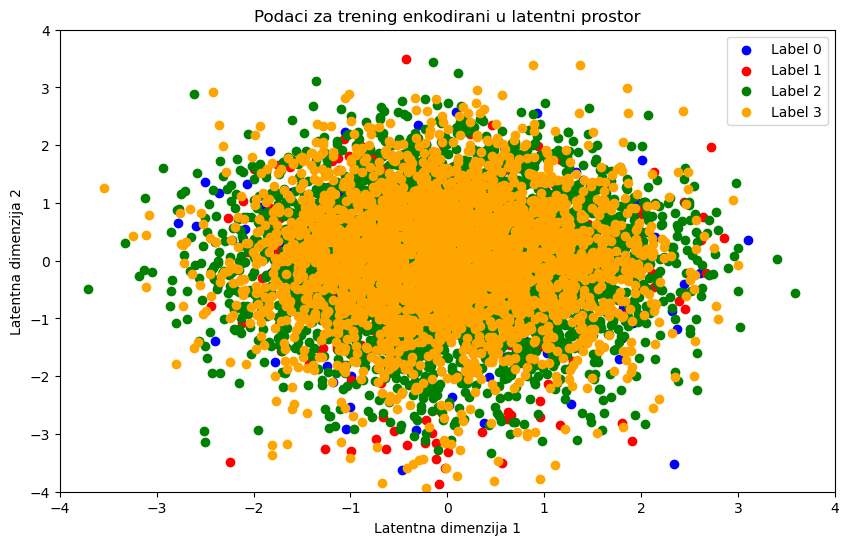

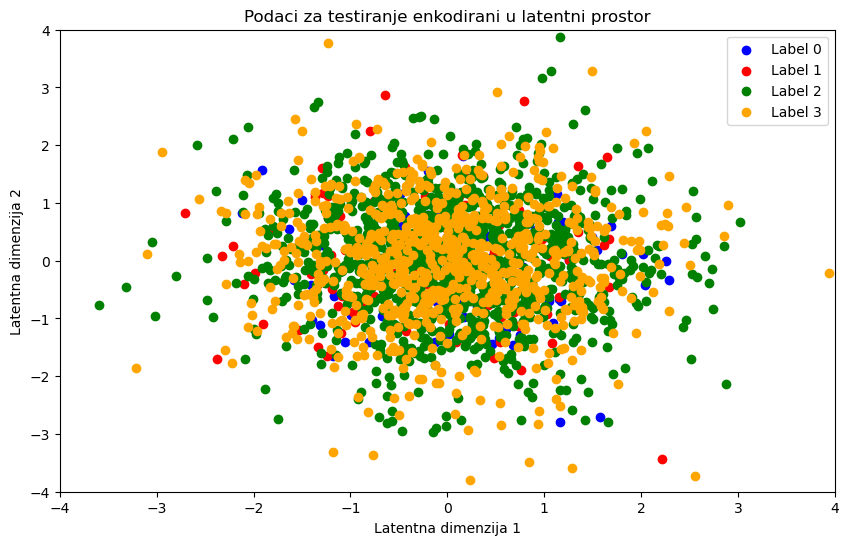

In [6]:
def plot_input_data(x_data, y_data):
    z_input = x_data
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za trening enkodirani u latentni prostor")
plot_input_data(z_input, y_train)

plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

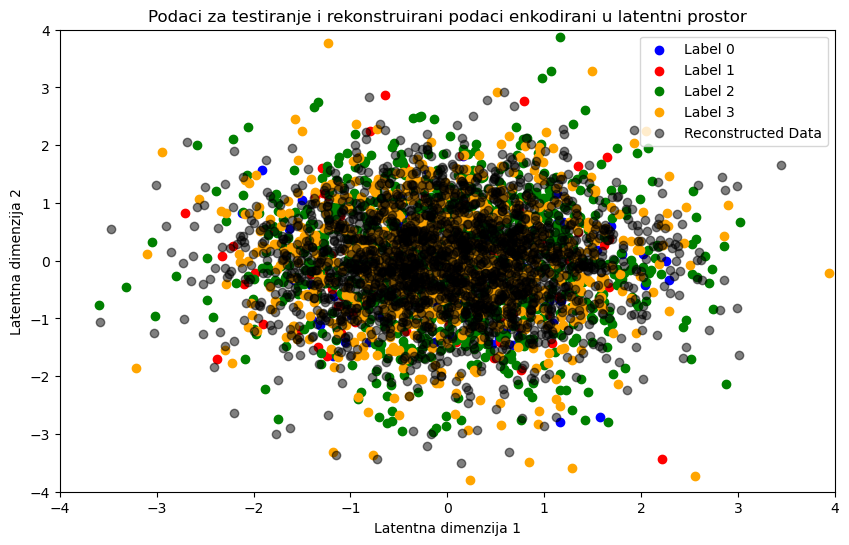

In [7]:
def plot_input_and_reconstructed_data(x_input_data, x_reconstructed, y_input_data):
    z_input = x_input_data
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_input_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_input_data == label)[0]
        plt.scatter(z_input[indices, 0], z_input[indices, 1], c=label_colors[label], label=f'Label {label}')

    plt.scatter(recon_data_lsp[:, 0], recon_data_lsp[:, 1], c='black', alpha=0.5, label='Reconstructed Data')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.title("Podaci za testiranje i rekonstruirani podaci enkodirani u latentni prostor")
    plt.legend()
    plt.show()

plt.figure(figsize=(10, 6))
plot_input_and_reconstructed_data(z_test_input, reconstructed_z_test_encoded, y_test)


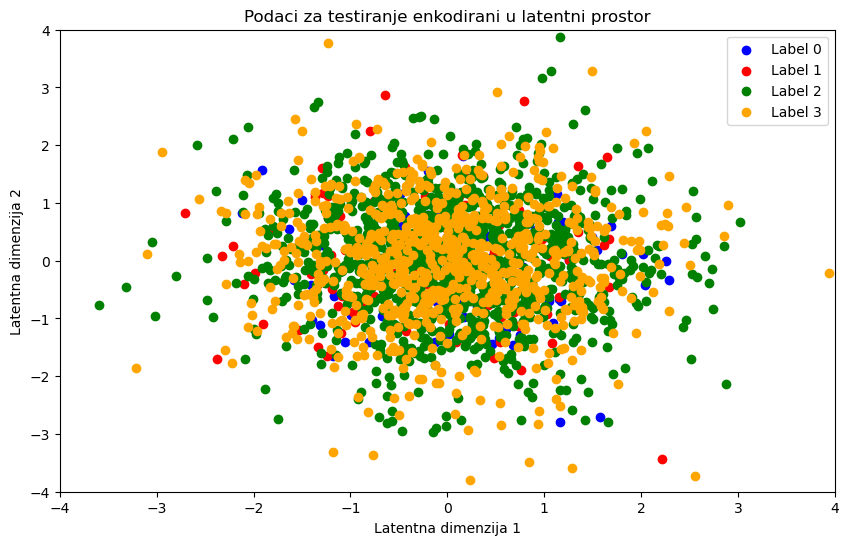

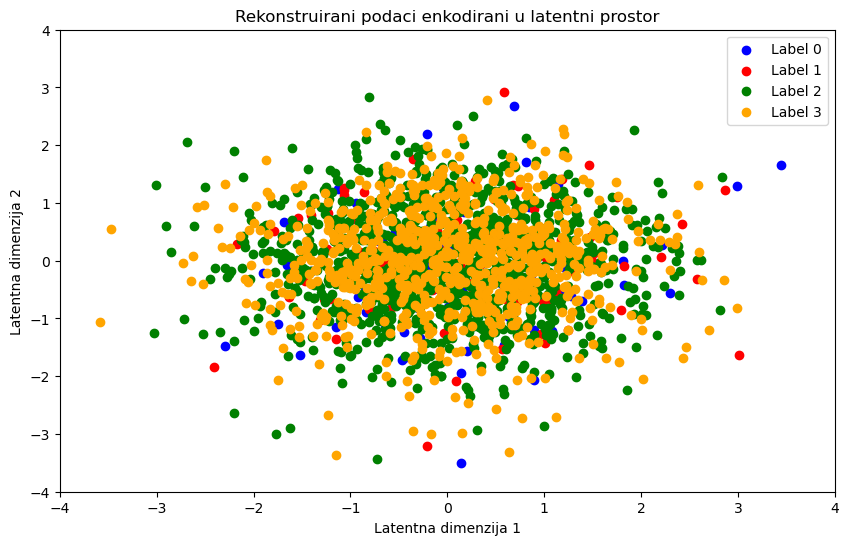

In [8]:
def plot_reconstructed_data(x_reconstructed, y_data):
    recon_data_lsp = x_reconstructed
    
    unique_labels = np.unique(y_data)
    label_colors = ['blue', 'red', 'green', 'orange']
    
    for label in unique_labels:
        indices = np.where(y_data == label)[0]
        plt.scatter(recon_data_lsp[indices, 0], recon_data_lsp[indices, 1], 
                    c=label_colors[label], label=f'Label {label}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()
    
plt.figure(figsize=(10, 6))
plt.title("Podaci za testiranje enkodirani u latentni prostor")
plot_input_data(z_test_input, y_test)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirani podaci enkodirani u latentni prostor")
plot_reconstructed_data(reconstructed_z_test_encoded, y_test)

1/1 [==============================] - 0s 14ms/step


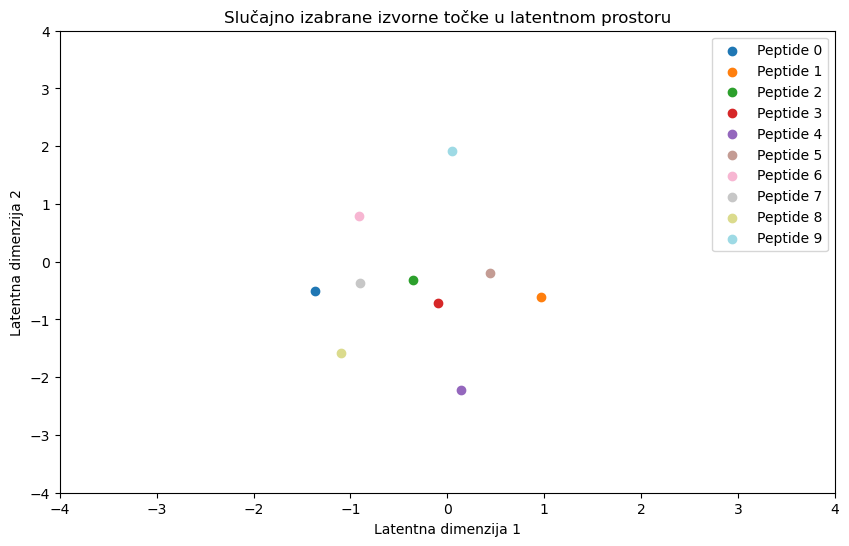

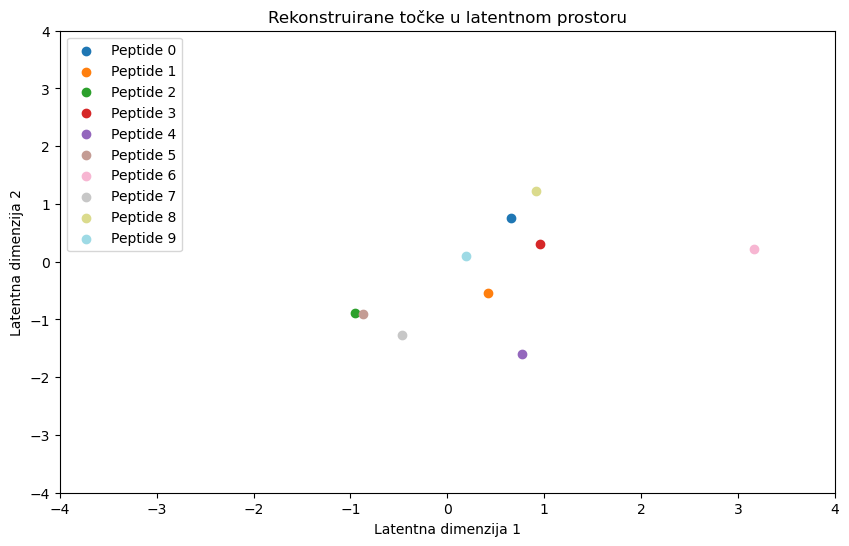

Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: 
 [2.3854096, 0.5550825, 0.8322579, 1.4677695, 0.8933427, 1.4892161, 4.118039, 1.0052248, 3.447043, 1.8226905] 

Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka:  1.8016075134277343


In [9]:
selected_indices = np.random.choice(len(x_test), 10, replace=False)

selected_peptides = x_test[selected_indices]

_, _, encoded_selected_peptides = vae.encoder.predict(selected_peptides)
reconstructed_peptides = vae.decoder.predict(encoded_selected_peptides)
_, _, encoded_reconstructed_peptides = vae.encoder.predict(reconstructed_peptides)


def plot_selected_data(x_data):
    z_input = x_data
    num_peptides = z_input.shape[0]
    unique_colors = plt.cm.tab20(np.linspace(0, 1, num_peptides))

    for i in range(num_peptides):
        plt.scatter(z_input[i, 0], z_input[i, 1], color=unique_colors[i], label=f'Peptide {i}')
    
    ax = plt.gca()
    ax.set_xlim([-4,4])
    ax.set_ylim([-4,4]) 
    plt.xlabel("Latentna dimenzija 1")
    plt.ylabel("Latentna dimenzija 2")
    plt.legend()
    plt.show()

    
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y)**2))


plt.figure(figsize=(10, 6))
plt.title("Slučajno izabrane izvorne točke u latentnom prostoru")
plot_selected_data(encoded_selected_peptides)

plt.figure(figsize=(10, 6))
plt.title("Rekonstruirane točke u latentnom prostoru")
plot_selected_data(encoded_reconstructed_peptides)


distances = []

for i in range(10):
    dist = euclidean_distance(encoded_selected_peptides[i], encoded_reconstructed_peptides[i])
        
    distances.append(dist)

print("Relativna udaljenost između svake pojedine točke i njoj pripadajuće rekonstruirane točke: \n", distances, "\n")
print("Prosječna relativna udaljenost između izvornih i rekonstruiranih točaka: ", np.sum(distances)/10)

In [10]:
#NORMALIZIRANA UDALJENOST U LATENTNOM PROSTORU

min_values = np.min(z_test_input, axis=0)
max_values = np.max(z_test_input, axis=0)

# Calculate the diagonal length of the latent space
latent_space_size = np.linalg.norm(max_values - min_values)
#print(min_values, max_values)
print(latent_space_size)

distances_test = []

for i in range(len(x_test)):
    dist = euclidean_distance(z_test_input[i], reconstructed_z_test_encoded[i])
        
    distances_test.append(dist)

print("Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka: ", 
      np.sum(distances_test)/latent_space_size/len(x_test))

10.753237
Normalizirana prosječna udaljenost između izvornih i rekonstruiranih točaka:  0.14552683492919455


In [11]:
#PEARSON
from scipy.stats import spearmanr, kendalltau, pearsonr

#print(x_test)
#print(reconstructed_z_test_input)

print(pearsonr(x_test.flatten(), reconstructed_z_test_input.flatten()))

PearsonRResult(statistic=0.7313182093249121, pvalue=0.0)


In [12]:
#RAZLIKA I RMSE

difference = x_test - reconstructed_z_test_input
print(np.abs(np.mean(difference)))

mse = np.mean(np.square(x_test - reconstructed_z_test_input))
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")


0.00042549118309655046
RMSE: 0.09700392563294752


In [13]:
from Bio import pairwise2
from Bio.Seq import Seq

def calculate_sequence_similarity(seq1, seq2):
  
    seq1 = Seq(seq1)
    seq2 = Seq(seq2)

    alignments = pairwise2.align.globalxx(seq1, seq2)

    best_alignment = alignments[0]
    seq1_aligned, seq2_aligned, score, begin, end = best_alignment

    similarity = (score / max(len(seq1), len(seq2)))

    return similarity

similarities_train = []
similarities_test = []

for i in range(50):
    row_similarities_train = []
    row_similarities_test = []
    for j in range(50,101):
        sim_train = calculate_sequence_similarity(x_train_seq[i], x_train_seq[j])
        sim_test = calculate_sequence_similarity(x_test_seq[i], x_test_seq[j])
        row_similarities_train.append(sim_train)
        row_similarities_test.append(sim_test)
        
    similarities_train.append(row_similarities_train)
    similarities_test.append(row_similarities_test)
    
similarities_train = np.array(similarities_train)
similarities_test = np.array(similarities_test)

print(similarities_train)
print(similarities_test)

[[0.25581395 0.13953488 0.39534884 ... 0.39534884 0.18604651 0.34883721]
 [0.1025641  0.         0.12820513 ... 0.13157895 0.125      0.05263158]
 [0.20512821 0.28       0.23076923 ... 0.18421053 0.32       0.23684211]
 ...
 [0.33333333 0.21621622 0.35897436 ... 0.34210526 0.32432432 0.34210526]
 [0.33333333 0.17777778 0.26666667 ... 0.33333333 0.22222222 0.33333333]
 [0.07692308 0.25       0.15384615 ... 0.18421053 0.16666667 0.23684211]]
[[0.27272727 0.18604651 0.27906977 ... 0.27906977 0.20930233 0.30232558]
 [0.36363636 0.25581395 0.27906977 ... 0.3255814  0.1627907  0.18604651]
 [0.25       0.17241379 0.26666667 ... 0.14285714 0.3        0.2       ]
 ...
 [0.15909091 0.31034483 0.33333333 ... 0.26190476 0.28571429 0.14285714]
 [0.34090909 0.2972973  0.54054054 ... 0.28571429 0.24324324 0.2972973 ]
 [0.09090909 0.13793103 0.06666667 ... 0.0952381  0.17647059 0.2       ]]


In [14]:
distances_train = []
distances_test = []

for i in range(50):
    row_distances_train = []
    row_distances_test = []
    for j in range(50,101):
        dist_train = euclidean_distance(z_input[i], z_input[j])
        dist_test = euclidean_distance(z_test_input[i], z_test_input[j])
        row_distances_train.append(dist_train)
        row_distances_test.append(dist_test)
        
    distances_train.append(row_distances_train)
    distances_test.append(row_distances_test)
        
distances_train = np.array(distances_train)
distances_test = np.array(distances_test)

normalized_distances_train = scaler.fit_transform(distances_train)
normalized_distances_test = scaler.fit_transform(distances_test)

print(normalized_distances_train)
print(normalized_distances_test)

[[0.8782435  0.28319916 0.45089686 ... 0.042533   0.30555362 0.48295978]
 [0.7093187  1.         0.99999994 ... 0.83803    1.         0.99999994]
 [0.5268405  0.404267   0.33368123 ... 0.14127007 0.4368806  0.14070794]
 ...
 [0.40000564 0.20227982 0.         ... 0.3390608  0.22537543 0.16996402]
 [0.20683467 0.37340242 0.13804331 ... 0.40475404 0.38756958 0.10353852]
 [0.13996297 0.64257354 0.5581497  ... 1.         0.5752058  0.8921961 ]]
[[1.         0.9821838  0.33429012 ... 0.78575116 0.79524404 0.4434635 ]
 [0.47924715 0.32248718 0.33403763 ... 0.1340074  0.05656008 0.24636629]
 [0.4227829  0.12597273 0.5249635  ... 0.33241847 0.23137334 0.46834955]
 ...
 [0.58929133 0.22491652 0.7644945  ... 0.6811557  0.5100093  0.7326933 ]
 [0.32100672 0.16602182 0.45495823 ... 0.21347213 0.28127536 0.4092351 ]
 [0.22494984 0.1712978  0.49882624 ... 0.28205118 0.4213397  0.47948846]]


In [15]:
correlation_train, p_value_train = spearmanr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = spearmanr(similarities_test.flatten(), distances_test.flatten())

print("Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = pearsonr(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = pearsonr(similarities_test.flatten(), distances_test.flatten())

print("Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test, "\n")

correlation_train, p_value_train = kendalltau(similarities_train.flatten(), distances_train.flatten())
correlation_test, p_value_test = kendalltau(similarities_test.flatten(), distances_test.flatten())

print("Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: \n", correlation_train, correlation_test)
print("p-value:", p_value_train, p_value_test)

Spearmanov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.15707007253046734 0.05114937797738445
p-value: 1.4954052109542064e-15 0.00978483943050976 

Pearsonov koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.2125500348333003 0.03139559883048011
p-value: 1.946469705569076e-27 0.11296328963620572 

Kendall tau koeficijent korelacije za skupove podataka za trening i testiranje: 
 -0.10596579439121974 0.0339409726859989
p-value: 1.353351084972223e-15 0.010555535051196862
